
## Using pre-trained word embeddings
### Introduction
Perform spam classification.  

The data can be downloaded from UCI machine learning repository: https://archive.ics.uci.edu/ml/machine-learning-databases/00228 
Information about the dataset can be found at   https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

*   A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages.
*   A subset of 3,375 SMS’s randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available.
*   A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis.
*   Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available.

**Attribute Information:**
The collection is composed by just one text file, where each line has the correct class followed by the raw message. The messages are not chronologically sorted. 

Examples:

spam I am not spam. subscribe to win money

ham Mary had a little lamb

Here are some examples bellow: 

ham What you doing?how are you? 

ham Ok lar... Joking wif u oni... 

ham dun say so early hor... U c already then say... 

ham MY NO. IN LUTON 0125698789 RING ME IF UR AROUND! H* 

ham Siva is in hostel aha:-. 

ham Cos i was out shopping wif darren jus now n i called him 2 ask wat present he wan lor. Then he started guessing who i was wif n he finally guessed darren lor.

spam FreeMsg: Txt: CALL to No: 86888 & claim your reward of 3 hours talk time to use from your phone now! ubscribe6GBP/ mnth inc 3hrs 16 stop?txtStop 
spam Sunshine Quiz! Win a super Sony DVD recorder if you canname the capital of Australia? Text MQUIZ to 82277. B 

spam URGENT! Your Mobile No 07808726822 was awarded a L2,000 Bonus Caller Prize on 02/09/03! This is our 2nd attempt to contact YOU! Call 0871-872-9758 BOX95QU 


In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

import sklearn as sk
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D,  MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import load_model


import nltk


2.3.0


In [3]:
# helper functions for visualisation
# plotting the loss functions used in this notebook
# we plot the loss we want to optimise on the left (in this case: accuracy)
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.epoch, np.array(history.history['accuracy']),'g-',
           label='Train accuracy')
  plt.plot(history.epoch, np.array(history.history['val_accuracy']),'r-',
           label = 'Validation accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Loss minimised by model')
  plt.plot(history.epoch, np.array(history.history['loss']),'g-',
           label='Train loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),'r-',
           label = 'Validation loss')
  plt.legend()

In [6]:
path = 'https://raw.githubusercontent.com/HOGENT-Databases/DB3-Workshops/master/data/'

df_dataset = pd.read_csv(path+"SMSSpamCollection.csv",sep='\t') 
df_dataset.columns
df_dataset.dtypes

label    object
text     object
dtype: object

In [7]:
# Take a look at the data
df_dataset.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Changing spam and ham into 0 and 1
df_dataset['label'] = np.where(df_dataset['label'] == "spam", 0, 1)
df_dataset.head()

,label,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Show the general information about the data
df_dataset.describe()

,label
count,5572.000000
mean,0.865937
std,0.340751
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [10]:
# What is the average length of the SMS messages. This will be important when we need to truncate the sequences to a maximum length
df_dataset['numberOfWords'] = df_dataset.text.str.split().apply(len)
df_dataset.head()

,label,text,numberOfWords
0,1,"Go until jurong point, crazy.. Available only ...",20
1,1,Ok lar... Joking wif u oni...,6
2,0,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,1,U dun say so early hor... U c already then say...,11
4,1,"Nah I don't think he goes to usf, he lives aro...",13


In [13]:
# Show the general information about the column numberOfWords
# Notice that 75% of the messages only consists of 23 words
df_dataset['numberOfWords'].describe()

count    5572.000000
mean       15.597452
std        11.404053
min         1.000000
25%         7.000000
50%        12.000000
75%        23.000000
max       171.000000
Name: numberOfWords, dtype: float64

In [14]:
# Extract a training & validation split
from sklearn.model_selection import train_test_split
X = df_dataset.drop(['label','numberOfWords'],axis=1)
y = df_dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(type(X_train))

X_train shape: (3900, 1)
X_test shape: (1672, 1)
3900 train samples
1672 test samples
<class 'pandas.core.frame.DataFrame'>


In [ ]:
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

print('X_train shape:', X_train.shape)
print(type(X_train))

X_train shape: (3900, 1)
<class 'numpy.ndarray'>


In [15]:
# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with a single '0' and a single '1', corresponding to the right class
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


# look at the new labels for the first sample
print(y_train[0])
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

[0. 1.]
y_train shape: (3900, 2)
y_test shape: (1672, 2)


### Create a vocabulary index

Let's use the TextVectorization to index the vocabulary found in the dataset. 

Deep Learning systems are often trained on very large datasets that will not fit in RAM. Ingesting a large dataset and preprocessing it efficiently can be tricky to implement with other Deep Learning libraries, but TensorFlow makes it easy thanks to the Data API: you just create a **dataset** object, and tell it where to get the data and how to transform it. TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, and prefetching.

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# max_tokens = integer parameter that will control the maximum size of the vocabulary. 
# We will only consider the top 20 000 words
# output_sequence_length = We will truncate or pad sequences to be actually 25 tokens long.
# This is the reason why we calculated the number of words for each message in a previouse step
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=25)

# Make a Dataset from a numpy array
# A tf.data.Dataset represents a potentially large set of elements.
text_ds = tf.data.Dataset.from_tensor_slices(X_train)

# Call the adapt method to build the vocabulary
vectorizer.adapt(text_ds)


In [26]:
# You can retrieve the computed vocabulary used via vectorizer.get_vocabulary(). 
# Let's print the top 5 words:
vectorizer.get_vocabulary()[:25]

['',
 '[UNK]',
 'to',
 'i',
 'you',
 'the',
 'a',
 'u',
 'and',
 'is',
 'in',
 'me',
 'for',
 'my',
 'your',
 'it',
 'of',
 'have',
 'call',
 'on',
 'that',
 'now',
 'are',
 '2',
 'im']

In [24]:
# Let's vectorize a test sentence:
output = vectorizer([["i saw the cat sat on the mat"]])
output.numpy()[0, :8]

array([   3,  518,    5, 6878,  473,   19,    5, 5369])

As you can see, "i" gets represented as "3". Why not 0, given that "i" was the second word in the vocabulary? That's because index 0 is reserved for padding and index 1 is reserved for "out of vocabulary" tokens.

Here's a dictionary mapping words to their indices:

In [29]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

As you can see, we obtain the same encoding as above for our test sentence:

In [30]:
test = ["i","saw","the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

[3, 518, 5, 6878, 473, 19, 5, 5369]

### Load pre-trained word embeddings
Let's download pre-trained GloVe embeddings (a 822M zip file).
Rather than training our own word vectors from scratch, we will leverage on GloVe. Its authors have released four text files with word vectors trained on different massive web datasets.

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones.

glove.6B = Wikipedia 2014 + Gigaword 5. It was trained on a corpus of 6 billion tokens and contains a vocabulary of 400 000 tokens.

You'll need to run the following commands:

In [ ]:

!wget http://nlp.stanford.edu/data/glove.6B.zip


--2020-12-10 05:13:49--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-10 05:13:49--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-10 05:13:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q glove.6B.zip

replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# After unzipping the downloaded file we find 4 txt files: glove.6B.50d.txt, glove.6B.100d.txt, glove.6B.200d.txt, glove.6B.300d.txt. 
# As their filenames suggests, they have vectors with different dimensions.
!ls '/content'

gdrive		   glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [ ]:
# move glove.6B.100d.txt to My Drive so it will be available for use in the furture
!mv '/content/glove.6B.100d.txt' '/content/gdrive/My Drive/glove.6B.100d.txt'

If we used glove.6B.50d.txt and we printed  the content of the file on console, we could see that each line contain as first element a word followed by 50 real numbers. For instance these are the first two lines, corresponding to tokens "the" and ",":

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581

, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [27]:
# we compute an index mapping words to known embeddings
# by parsing the data dump of pre-trained embeddings:

path_to_glove_file = '/content/gdrive/My Drive/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [38]:
num_tokens = len(voc) + 2
# each word is represented by a vector of 100 floats (glove.6B.100d.txt)
embedding_dim = 100
hits = 0
misses = 0
missed_words = []

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
# word_index is a dictionary that maps each word to an index
# we loop through all the words of word_index.items()
for word, i in word_index.items():
# we try to retrieve the vector of 100 floats for this word out of embeddings_index  
    embedding_vector = embeddings_index.get(word)
# if we found the corresponding vector of 100 floats    
    if embedding_vector is not None:
      # we put the vector on position i of embedding_matrix
        embedding_matrix[i] = embedding_vector
        hits += 1    
    else:
      # Words not found in embedding index will be all-zeros.    
        misses += 1
        missed_words.append(word)
        
print("Converted %d words (%d misses)" % (hits, misses))

print("*** Missed words = words not in word_index ***")
print(missed_words[0:10])
print()
print("*** i has which index in word_index? ***")
index_i = word_index['i']
print(index_i)
print()
print("*** the vector of 100 floats representing i ***")
print(embedding_matrix[index_i])
print()
print("*** cat has which index in word_index? ***")
index_cat = word_index['cat']
print(index_cat)
print()
print("*** the vector of 100 floats representing cat ***")
print(embedding_matrix[index_cat])

Converted 5408 words (2461 misses)
*** Missed words = words not in word_index ***
['', '[UNK]', 'ltgt', 'Ü', '£1000', '£2000', '£150', 'thanx', '150ppm', 'aight']

*** i has which index in word_index ***
3

*** the vector of 100 floats representing i ***
[-0.046539    0.61966002  0.56647003 -0.46584001 -1.18900001  0.44599
  0.066035    0.31909999  0.14679    -0.22119001  0.79238999  0.29905
  0.16073     0.025324    0.18678001 -0.31000999 -0.28108001  0.60514998
 -1.0654      0.52476001  0.064152    1.03579998 -0.40779001 -0.38011
  0.30801001  0.59964001 -0.26991001 -0.76034999  0.94221997 -0.46919
 -0.18278     0.90652001  0.79671001  0.24824999  0.25713     0.6232
 -0.44768     0.65357     0.76902002 -0.51229    -0.44332999 -0.21867
  0.38370001 -1.14830005 -0.94397998 -0.15062     0.30012    -0.57805997
  0.20175    -1.65910006 -0.079195    0.026423    0.22051001  0.99713999
 -0.57538998 -2.72659993  0.31448001  0.70521998  1.43809998  0.99125999
  0.13976     1.34739995 -1.1753  

### Build the model

We load the pre-trained word embeddings matrix into an Embedding layer.
All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embedding_matrix[1], embedding_matrix[2]].
Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

A simple 1D convnet with global max pooling and a classifier at the end.
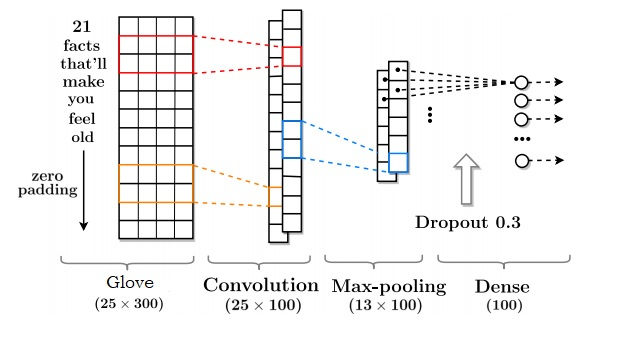

In [ ]:
num_classes = 2

def initial_model():
    # we create a variable called model, and we set it equal to an instance of a Sequential object.
    model = Sequential()

    model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
    model.add(Conv1D(16,activation='relu',kernel_size=3))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(16,activation='relu',kernel_size=3))
    model.add(MaxPooling1D(3))    
    model.add(Conv1D(16,activation='relu',kernel_size=3))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))    
    model.add(Dropout(0.5))      
    model.add(Dense(num_classes, activation='softmax'))


    # Before we can train our model, we must compile it
    # To the compile() function, we are passing the optimizer, the loss function, and the metrics that we would like to see. 
    # Notice that the optimizer we have specified is called Adam. Adam is just a variant of SGD. 
    model.compile(loss='categorical_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),
                  metrics=['accuracy']) 
    return model


### Train the model
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [ ]:
X_train_final = vectorizer(np.array([s for s in X_train])).numpy()
X_test_final = vectorizer(np.array([s for s in X_test])).numpy()

y_train_final = np.array(y_train)
y_test_final = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_train_final.shape)
print(X_test_final.shape)
print(y_train_final.shape)
print(y_test_final.shape)

(3900, 1)
(1672, 1)
(3900, 50)
(1672, 50)
(3900, 2)
(1672, 2)


In [ ]:
model_1 = initial_model()
model_1.summary()


# We now add batch size to the mix of training parameters
# If you don't specify batch size below, all training data will be used for each learning step
batch_size = 32
epochs = 10

history_1 = model_1.fit(X_train_final, y_train_final,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test_final, y_test_final)
                    )



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         793300    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, None, 16)          4816      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, None, 16)          784       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, None, 16)          784       
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 16)               

Training set Accuracy:   1.00
Training set Loss: 0.0146

Validation set Accuracy:   0.98
Validation set Loss: 0.0818



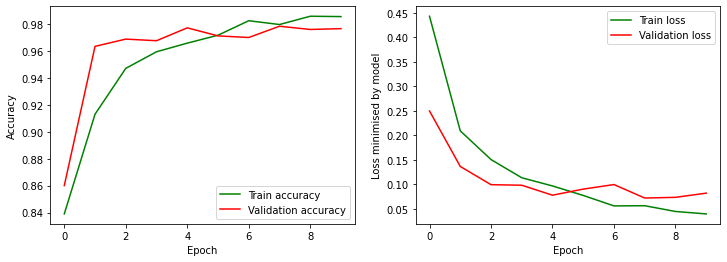

In [ ]:
# model_1 now contains the model at the end of the training run
# We analyse the result:

[train_loss, train_accuracy] = model_1.evaluate(X_train_final, y_train_final, verbose=0)
print("Training set Accuracy:{:7.2f}".format(train_accuracy))
print("Training set Loss:{:7.4f}\n".format(train_loss))

[val_loss, val_accuracy] = model_1.evaluate(X_test_final, y_test_final, verbose=0)
print("Validation set Accuracy:{:7.2f}".format(val_accuracy))
print("Validation set Loss:{:7.4f}\n".format(val_loss))

#Now we visualise what happened during training
plot_history(history_1)

In [ ]:
X_example = vectorizer(np.array([s for s in ["URGENT! Your Mobile No. was awarded a €2000 Bonus Caller Prize"]])).numpy()
pred = model_1.predict([X_example])
print(pred)

[[0.97710335 0.02289662]]


In [ ]:
X_example = vectorizer(np.array([s for s in ["Please call me"]])).numpy()
pred = model_1.predict([X_example])
print(pred)

[[9.788587e-04 9.990212e-01]]
